# Import requirements

In [1]:
import sys
sys.path.append("../src")
import os
import pdb
import math
from scipy.io import loadmat
import torch
import numpy as np
import matplotlib.pyplot as plt
from kernelMatricesStore import KernelMatricesStore
from kernels import PeriodicKernel, ExponentialQuadraticKernel
from approxPosteriorForH import ApproxPosteriorForHForAllNeuronsAllTimes, ApproxPosteriorForHForAllNeuronsAssociatedTimes
from inducingPointsPrior import InducingPointsPrior
from expectedLogLikelihood import PointProcessExpectedLogLikelihood, PoissonExpectedLogLikelihood
from sparseVariationalLowerBound import SparseVariationalLowerBound
from klDivergence import KLDivergence
from sparseVariationalEM import SparseVariationalEM

# Load data and initial values

In [2]:
dataFilename = os.path.expanduser("data/demo_PointProcess.mat")
mat = loadmat(dataFilename)
nLatents = len(mat['Z0'])
nTrials = mat['Z0'][0,0].shape[2]
qMu = [torch.from_numpy(mat['q_mu0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSVec = [torch.from_numpy(mat['q_sqrt0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSDiag = [torch.from_numpy(mat['q_diag0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
t = torch.from_numpy(mat['ttQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
Z = [torch.from_numpy(mat['Z0'][(i,0)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
Y = [torch.from_numpy(mat['Y'][tr,0]).type(torch.DoubleTensor) for tr in range(nTrials)]
index = [torch.from_numpy(mat["index"][i,0][:,0]).type(torch.ByteTensor) for i in range(nTrials)]
C = torch.from_numpy(mat["C0"]).type(torch.DoubleTensor)
b = torch.from_numpy(mat["b0"]).type(torch.DoubleTensor).squeeze()
legQuadPoints = torch.from_numpy(mat['ttQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
legQuadWeights = torch.from_numpy(mat['wwQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
hermQuadPoints = torch.from_numpy(mat['xxHerm']).type(torch.DoubleTensor)
hermQuadWeights = torch.from_numpy(mat['wwHerm']).type(torch.DoubleTensor)
kernelNames = mat["kernelNames"]
hprs = mat["hprs0"]
testTimes = torch.from_numpy(mat['testTimes']).type(torch.DoubleTensor).squeeze()
trueLatents = [[torch.from_numpy(mat['trueLatents'][tr,k]).type(torch.DoubleTensor) for tr in range(nTrials)] for k in range(nLatents)]
linkFunction = torch.exp
kernels = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], 'PeriodicKernel'):
        kernels[k] = PeriodicKernel(scale=1.0, lengthScale=float(hprs[k,0][0]), period=float(hprs[k,0][1]))
    elif np.char.equal(kernelNames[0,k][0], 'rbfKernel'):
        kernels[k] = ExponentialQuadraticKernel(scale=1.0, lengthScale=float(hprs[k,0][0]))
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))

# Create svGPFA Objects

In [3]:
qU = InducingPointsPrior(qMu=qMu, qSVec=qSVec, qSDiag=qSDiag, varRnk=torch.ones(3,dtype=torch.uint8))
kernelMatricesStore= KernelMatricesStore(kernels=kernels, Z=Z, t=t, Y=Y)
qH_allNeuronsAllTimes = ApproxPosteriorForHForAllNeuronsAllTimes(C=C, d=b, inducingPointsPrior=qU, kernelMatricesStore=kernelMatricesStore)
qH_allNeuronsAssociatedTimes = ApproxPosteriorForHForAllNeuronsAssociatedTimes(C=C, d=b, inducingPointsPrior=qU, kernelMatricesStore=kernelMatricesStore, neuronForSpikeIndex=index)
eLL = PointProcessExpectedLogLikelihood(approxPosteriorForHForAllNeuronsAllTimes=qH_allNeuronsAllTimes, approxPosteriorForHForAllNeuronsAssociatedTimes=qH_allNeuronsAssociatedTimes, hermQuadPoints=hermQuadPoints, hermQuadWeights=hermQuadWeights, legQuadPoints=legQuadPoints, legQuadWeights=legQuadWeights, linkFunction=linkFunction)
klDiv = KLDivergence(kernelMatricesStore=kernelMatricesStore, inducingPointsPrior=qU)
svLB = SparseVariationalLowerBound(eLL=eLL, klDiv=klDiv)
svEM = SparseVariationalEM(lowerBound=svLB, eLL=eLL, kernelMatricesStore=kernelMatricesStore)

# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters below, this step takes around 15 minutes)</span>

In [4]:
maxRes = svEM.maximize(emMaxNIter=50, eStepMaxNIter=50, mStepModelParamsMaxNIter=50, mStepKernelParamsMaxNIter=50, mStepKernelParamsLR=1e-5, mStepInducingPointsMaxNIter=50)

Iteration 00, E-Step start
Iteration: 0, negative lower bound: 6180.619714
Iteration: 10, negative lower bound: 5897.443745
Iteration: 20, negative lower bound: 5842.268679
Iteration: 30, negative lower bound: 5817.135911
Iteration: 40, negative lower bound: 5796.152578
Iteration 00, E-Step end: 5779.510134
Iteration 00, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 5465.384625
Iteration: 10, negative sum of expected log likelihood: 5445.059458
Iteration: 20, negative sum of expected log likelihood: 5425.724674
Iteration: 30, negative sum of expected log likelihood: 5407.401650
Iteration: 40, negative sum of expected log likelihood: 5390.050026
Iteration 00, M-Step Model Params end: 5375.205944
Iteration 00, M-Step Kernel Params start
Iteration: 0, negative lower bound: 5686.264706
Iteration: 10, negative lower bound: 5676.461573
Iteration: 20, negative lower bound: 5672.563180
Iteration: 30, negative lower bound: 5668.603493
Iteration: 40, negative l

Iteration: 10, negative lower bound: 4990.641069
Iteration: 20, negative lower bound: 4984.601534
Iteration: 30, negative lower bound: 4980.147846
Iteration: 40, negative lower bound: 4978.435121
Iteration 05, M-Step Inducing Points end: 4977.445556
Iteration 06, E-Step start
Iteration: 0, negative lower bound: 4977.422746
Iteration: 10, negative lower bound: 4972.703411
Iteration: 20, negative lower bound: 4967.741097
Iteration: 30, negative lower bound: 4963.714995
Iteration: 40, negative lower bound: 4960.060371
Iteration 06, E-Step end: 4956.943366
Iteration 06, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4744.366688
Iteration: 10, negative sum of expected log likelihood: 4740.648545
Iteration: 20, negative sum of expected log likelihood: 4737.383743
Iteration: 30, negative sum of expected log likelihood: 4734.424557
Iteration: 40, negative sum of expected log likelihood: 4731.742284
Iteration 06, M-Step Model Params end: 4729.540053
Iteration 0

Iteration: 20, negative lower bound: 4832.993730
Iteration: 30, negative lower bound: 4832.941805
Iteration: 40, negative lower bound: 4832.927082
Iteration 11, M-Step Kernel Params end: 4832.908286
Iteration 11, M-Step Inducing Points start
Iteration: 0, negative lower bound: 4832.906075
Iteration: 10, negative lower bound: 4857.712909
Iteration: 20, negative lower bound: 4839.001619
Iteration: 30, negative lower bound: 4835.536907
Iteration: 40, negative lower bound: 4833.073033
Iteration 11, M-Step Inducing Points end: 4831.764898
Iteration 12, E-Step start
Iteration: 0, negative lower bound: 4831.785011
Iteration: 10, negative lower bound: 4830.803945
Iteration: 20, negative lower bound: 4828.091266
Iteration: 30, negative lower bound: 4826.314534
Iteration: 40, negative lower bound: 4824.887351
Iteration 12, E-Step end: 4823.665951
Iteration 12, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4629.618750
Iteration: 10, negative sum of expected log 

Iteration: 40, negative sum of expected log likelihood: 4592.575736
Iteration 17, M-Step Model Params end: 4592.573640
Iteration 17, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4781.147291
Iteration: 10, negative lower bound: 4781.501924
Iteration: 20, negative lower bound: 4781.163801
Iteration: 30, negative lower bound: 4781.096253
Iteration: 40, negative lower bound: 4781.090134
Iteration 17, M-Step Kernel Params end: 4781.076461
Iteration 17, M-Step Inducing Points start
Iteration: 0, negative lower bound: 4781.073631
Iteration: 10, negative lower bound: 4806.086668
Iteration: 20, negative lower bound: 4788.041105
Iteration: 30, negative lower bound: 4783.496608
Iteration: 40, negative lower bound: 4781.137384
Iteration 17, M-Step Inducing Points end: 4780.382351
Iteration 18, E-Step start
Iteration: 0, negative lower bound: 4780.292423
Iteration: 10, negative lower bound: 4779.820008
Iteration: 20, negative lower bound: 4777.841839
Iteration: 30, negative lower 

Iteration: 10, negative sum of expected log likelihood: 4568.513810
Iteration: 20, negative sum of expected log likelihood: 4568.506409
Iteration: 30, negative sum of expected log likelihood: 4568.504269
Iteration: 40, negative sum of expected log likelihood: 4568.503426
Iteration 23, M-Step Model Params end: 4568.503188
Iteration 23, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4751.118695
Iteration: 10, negative lower bound: 4751.591579
Iteration: 20, negative lower bound: 4751.180201
Iteration: 30, negative lower bound: 4751.087683
Iteration: 40, negative lower bound: 4751.084816
Iteration 23, M-Step Kernel Params end: 4751.075425
Iteration 23, M-Step Inducing Points start
Iteration: 0, negative lower bound: 4751.071420
Iteration: 10, negative lower bound: 4777.478184
Iteration: 20, negative lower bound: 4758.050066
Iteration: 30, negative lower bound: 4754.189834
Iteration: 40, negative lower bound: 4751.820456
Iteration 23, M-Step Inducing Points end: 4750.981868

Iteration: 20, negative lower bound: 4733.786451
Iteration: 30, negative lower bound: 4733.241032
Iteration: 40, negative lower bound: 4732.938974
Iteration 29, E-Step end: 4732.691447
Iteration 29, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4553.910355
Iteration: 10, negative sum of expected log likelihood: 4553.819374
Iteration: 20, negative sum of expected log likelihood: 4553.811470
Iteration: 30, negative sum of expected log likelihood: 4553.809996
Iteration: 40, negative sum of expected log likelihood: 4553.808953
Iteration 29, M-Step Model Params end: 4553.808621
Iteration 29, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4732.560554
Iteration: 10, negative lower bound: 4733.099774
Iteration: 20, negative lower bound: 4732.632348
Iteration: 30, negative lower bound: 4732.535629
Iteration: 40, negative lower bound: 4732.537244
Iteration 29, M-Step Kernel Params end: 4732.529647
Iteration 29, M-Step Inducing Points start
Itera

Iteration: 30, negative lower bound: 4725.492403
Iteration: 40, negative lower bound: 4723.025341
Iteration 34, M-Step Inducing Points end: 4721.906185
Iteration 35, E-Step start
Iteration: 0, negative lower bound: 4721.721475
Iteration: 10, negative lower bound: 4722.167366
Iteration: 20, negative lower bound: 4720.877842
Iteration: 30, negative lower bound: 4720.503409
Iteration: 40, negative lower bound: 4720.332216
Iteration 35, E-Step end: 4720.194414
Iteration 35, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4545.857772
Iteration: 10, negative sum of expected log likelihood: 4545.796340
Iteration: 20, negative sum of expected log likelihood: 4545.792928
Iteration: 30, negative sum of expected log likelihood: 4545.791686
Iteration: 40, negative sum of expected log likelihood: 4545.791197
Iteration 35, M-Step Model Params end: 4545.791053
Iteration 35, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4720.111698
Iteration: 10, negat

Iteration: 40, negative lower bound: 4716.871128
Iteration 40, M-Step Kernel Params end: 4716.867709
Iteration 40, M-Step Inducing Points start
Iteration: 0, negative lower bound: 4716.861325
Iteration: 10, negative lower bound: 4749.314892
Iteration: 20, negative lower bound: 4726.907366
Iteration: 30, negative lower bound: 4722.895880
Iteration: 40, negative lower bound: 4720.293995
Iteration 40, M-Step Inducing Points end: 4718.953683
Iteration 41, E-Step start
Iteration: 0, negative lower bound: 4719.020195
Iteration: 10, negative lower bound: 4718.958561
Iteration: 20, negative lower bound: 4717.660651
Iteration: 30, negative lower bound: 4717.197926
Iteration: 40, negative lower bound: 4716.969278
Iteration 41, E-Step end: 4716.804084
Iteration 41, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4541.740102
Iteration: 10, negative sum of expected log likelihood: 4541.708127
Iteration: 20, negative sum of expected log likelihood: 4541.706531
Iterat

Iteration 46, M-Step Model Params end: 4538.361961
Iteration 46, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4712.218230
Iteration: 10, negative lower bound: 4712.907165
Iteration: 20, negative lower bound: 4712.333789
Iteration: 30, negative lower bound: 4712.197577
Iteration: 40, negative lower bound: 4712.200737
Iteration 46, M-Step Kernel Params end: 4712.198663
Iteration 46, M-Step Inducing Points start
Iteration: 0, negative lower bound: 4712.191245
Iteration: 10, negative lower bound: 4744.915695
Iteration: 20, negative lower bound: 4718.365044
Iteration: 30, negative lower bound: 4717.152579
Iteration: 40, negative lower bound: 4714.002970
Iteration 46, M-Step Inducing Points end: 4712.946416
Iteration 47, E-Step start
Iteration: 0, negative lower bound: 4712.759012
Iteration: 10, negative lower bound: 4713.057612
Iteration: 20, negative lower bound: 4711.964790
Iteration: 30, negative lower bound: 4711.708712
Iteration: 40, negative lower bound: 4711.620675


# Predict Latent Variables at New Times

In [5]:
qHMu, qHVar, qKMu, qKVar = qH_allNeuronsAllTimes.predict(testTimes=testTimes)

# Plot Latent Estimates for One Trial

<IPython.core.display.Javascript object>


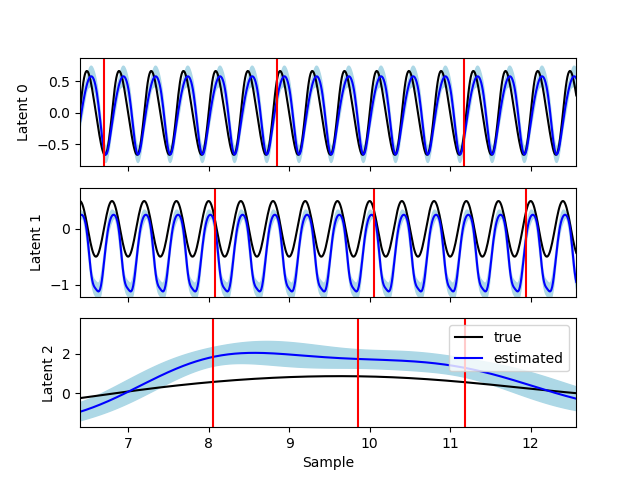

In [8]:
%matplotlib notebook
Z = qH_allNeuronsAllTimes._kernelMatricesStore.getZ()
testTimesToPlot = testTimes.numpy()
trialToPlot = 0
f, axes = plt.subplots(nLatents, 1, sharex=True)
for k in range(nLatents):
    trueLatentToPlot = trueLatents[k][trialToPlot].numpy().squeeze()
    qKMuToPlot = qKMu[trialToPlot,:,k].numpy()
    errorToPlot = qKVar[trialToPlot,:,k].sqrt().numpy()
    axes[k].plot(testTimesToPlot, trueLatentToPlot, label="true", color="black")
    axes[k].plot(testTimesToPlot, qKMuToPlot, label="estimated", color="blue")
    axes[k].fill_between(testTimesToPlot, qKMuToPlot-errorToPlot, qKMuToPlot+errorToPlot, color="lightblue")
    for i in range(Z[k].shape[1]):
        axes[k].axvline(x=Z[k][trialToPlot,i, 0], color="red")
    axes[k].set_ylabel("Latent %d"%(k))
axes[-1].set_xlabel("Sample")
axes[-1].legend()
plt.xlim(left=np.min(testTimesToPlot)-1, right=np.max(testTimesToPlot)+1)
plt.show()